In [13]:
!conda install -c conda-forge libstdcxx-ng -y
!pip install --force-reinstall scipy statsmodels --quiet
!pip install pmdarima --quiet


Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda 24.7.1 requires pluggy>=1.0.0, but you have pluggy 1.0.0.dev0 which is incompatible.
recmetrics 0.1.5 requires pandas<2.0.0,>=1.1.3, but you have pandas 2.0.3 which is incompatible.


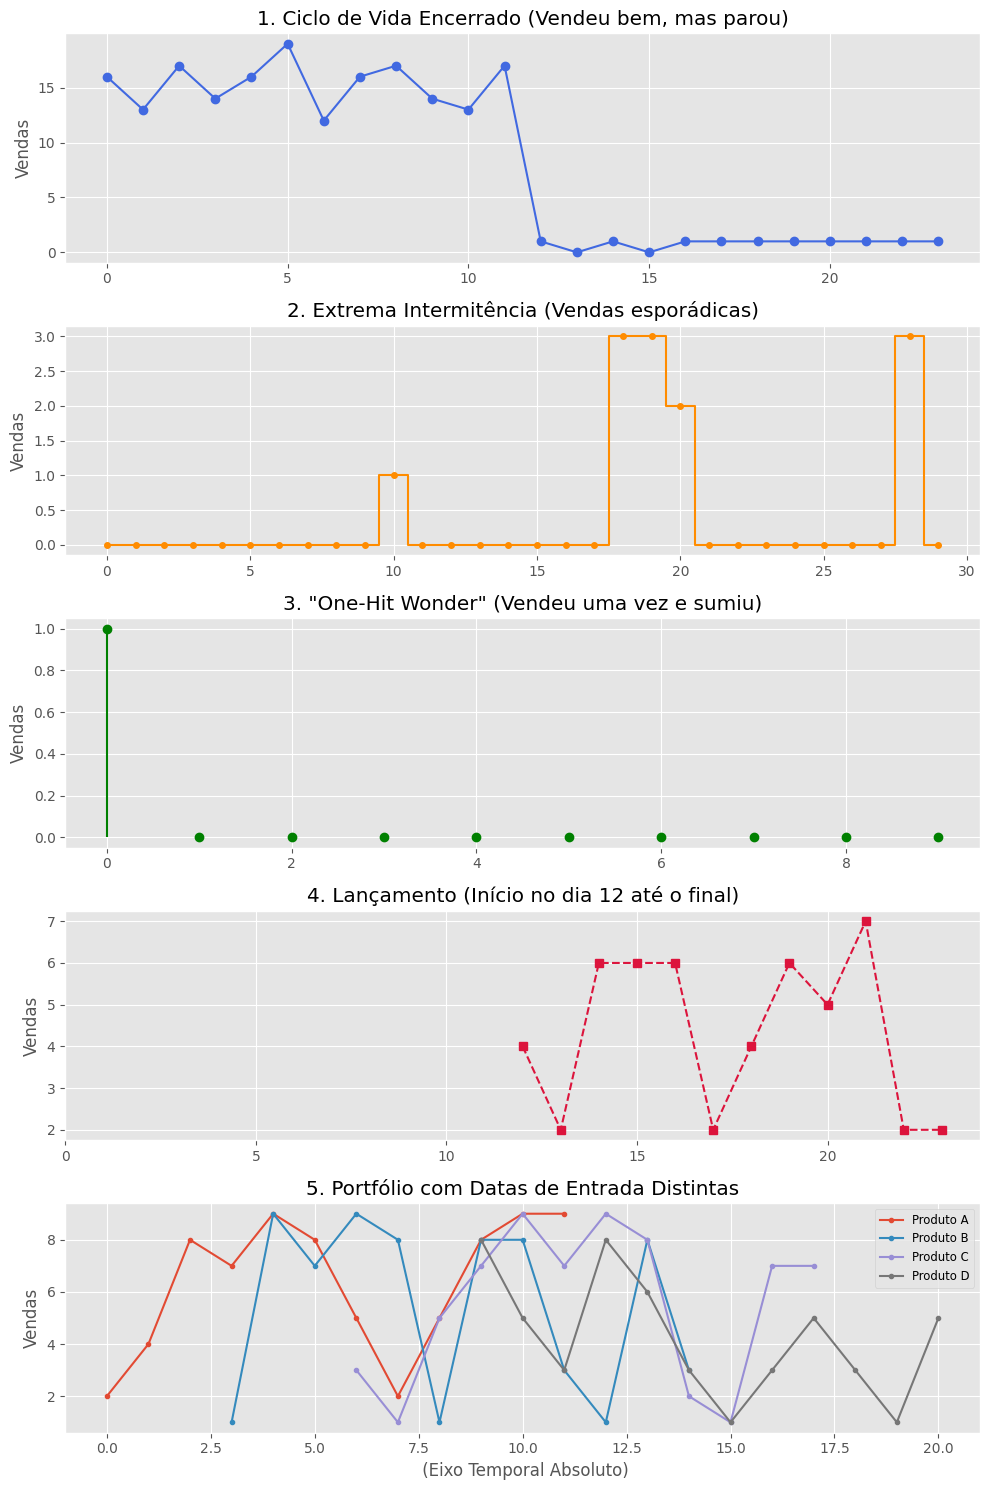

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
# Configurações gerais de estilo
plt.style.use('ggplot') # Um estilo mais visual que o 'default'

# Criando a figura com 5 subplots (5 linhas, 1 coluna)
fig, axs = plt.subplots(5, 1, figsize=(10, 15))

# --- Série 1: Produtos que venderam bem no passado e pararam ---
x1 = np.arange(0, 24) # 24 meses
# Concatenamos 12 meses de vendas (10-20) com 12 meses de "limbo" (0-1)
y1 = np.concatenate([
    np.random.randint(10, 20, size=12), 
    np.random.randint(0, 2, size=12)
])
axs[0].plot(x1, y1, marker='o', color='royalblue')
axs[0].set_title('1. Ciclo de Vida Encerrado (Vendeu bem, mas parou)')
axs[0].set_ylabel('Vendas')

# --- Série 2: Produtos com extrema intermitência ---
x2 = np.arange(0, 30) # 30 dias
y2 = np.random.choice([0, 1, 2, 3], size=30, p=[0.7, 0.1, 0.1, 0.1])
axs[1].step(x2, y2, where='mid', color='darkorange', marker='o', markersize=4)
axs[1].set_title('2. Extrema Intermitência (Vendas esporádicas)')
axs[1].set_ylabel('Vendas')

# --- Série 3: Produtos que vendem 1 unidade e param ---
x3 = np.arange(0, 10) # 10 dias
y3 = np.where(x3 == 0, 1, 0)
axs[2].stem(x3, y3, linefmt='green', markerfmt='go', basefmt=" ")
axs[2].set_title('3. "One-Hit Wonder" (Vendeu uma vez e sumiu)')
axs[2].set_ylabel('Vendas')

# --- Série 4: Produtos que começaram a vender recentemente ---
# --- Série 4: Lançamento do mês 12 até o final (24) ---
x4 = np.arange(12, 24) # Começa em 12, vai até 23 (total de 12 pontos)
y4 = np.random.randint(1, 8, size=12) # Geramos 12 valores para bater com o x4

axs[3].plot(x4, y4, marker='s', color='crimson', linestyle='--')
axs[3].set_title('4. Lançamento (Início no dia 12 até o final)')
axs[3].set_ylabel('Vendas')

# Mantemos o limite de 0 a 24 para visualizar o "vazio" antes do lançamento
axs[3].set_xlim(0, 24)
# --- Série 5: Produtos com datas de início/fim diferentes ---
# Criando diferentes janelas temporais
axs[4].plot(np.arange(0, 12), np.random.randint(1, 10, 12), marker='.', label='Produto A')
axs[4].plot(np.arange(3, 15), np.random.randint(1, 10, 12), marker='.', label='Produto B')
axs[4].plot(np.arange(6, 18), np.random.randint(1, 10, 12), marker='.', label='Produto C')
axs[4].plot(np.arange(9, 21), np.random.randint(1, 10, 12), marker='.', label='Produto D')
axs[4].set_title('5. Portfólio com Datas de Entrada Distintas')
axs[4].set_xlabel(' (Eixo Temporal Absoluto)')
axs[4].set_ylabel('Vendas')
axs[4].legend(loc='upper right', fontsize='small')

# Ajuste fino para evitar que os gráficos fiquem "espremidos"
plt.tight_layout()
plt.show()

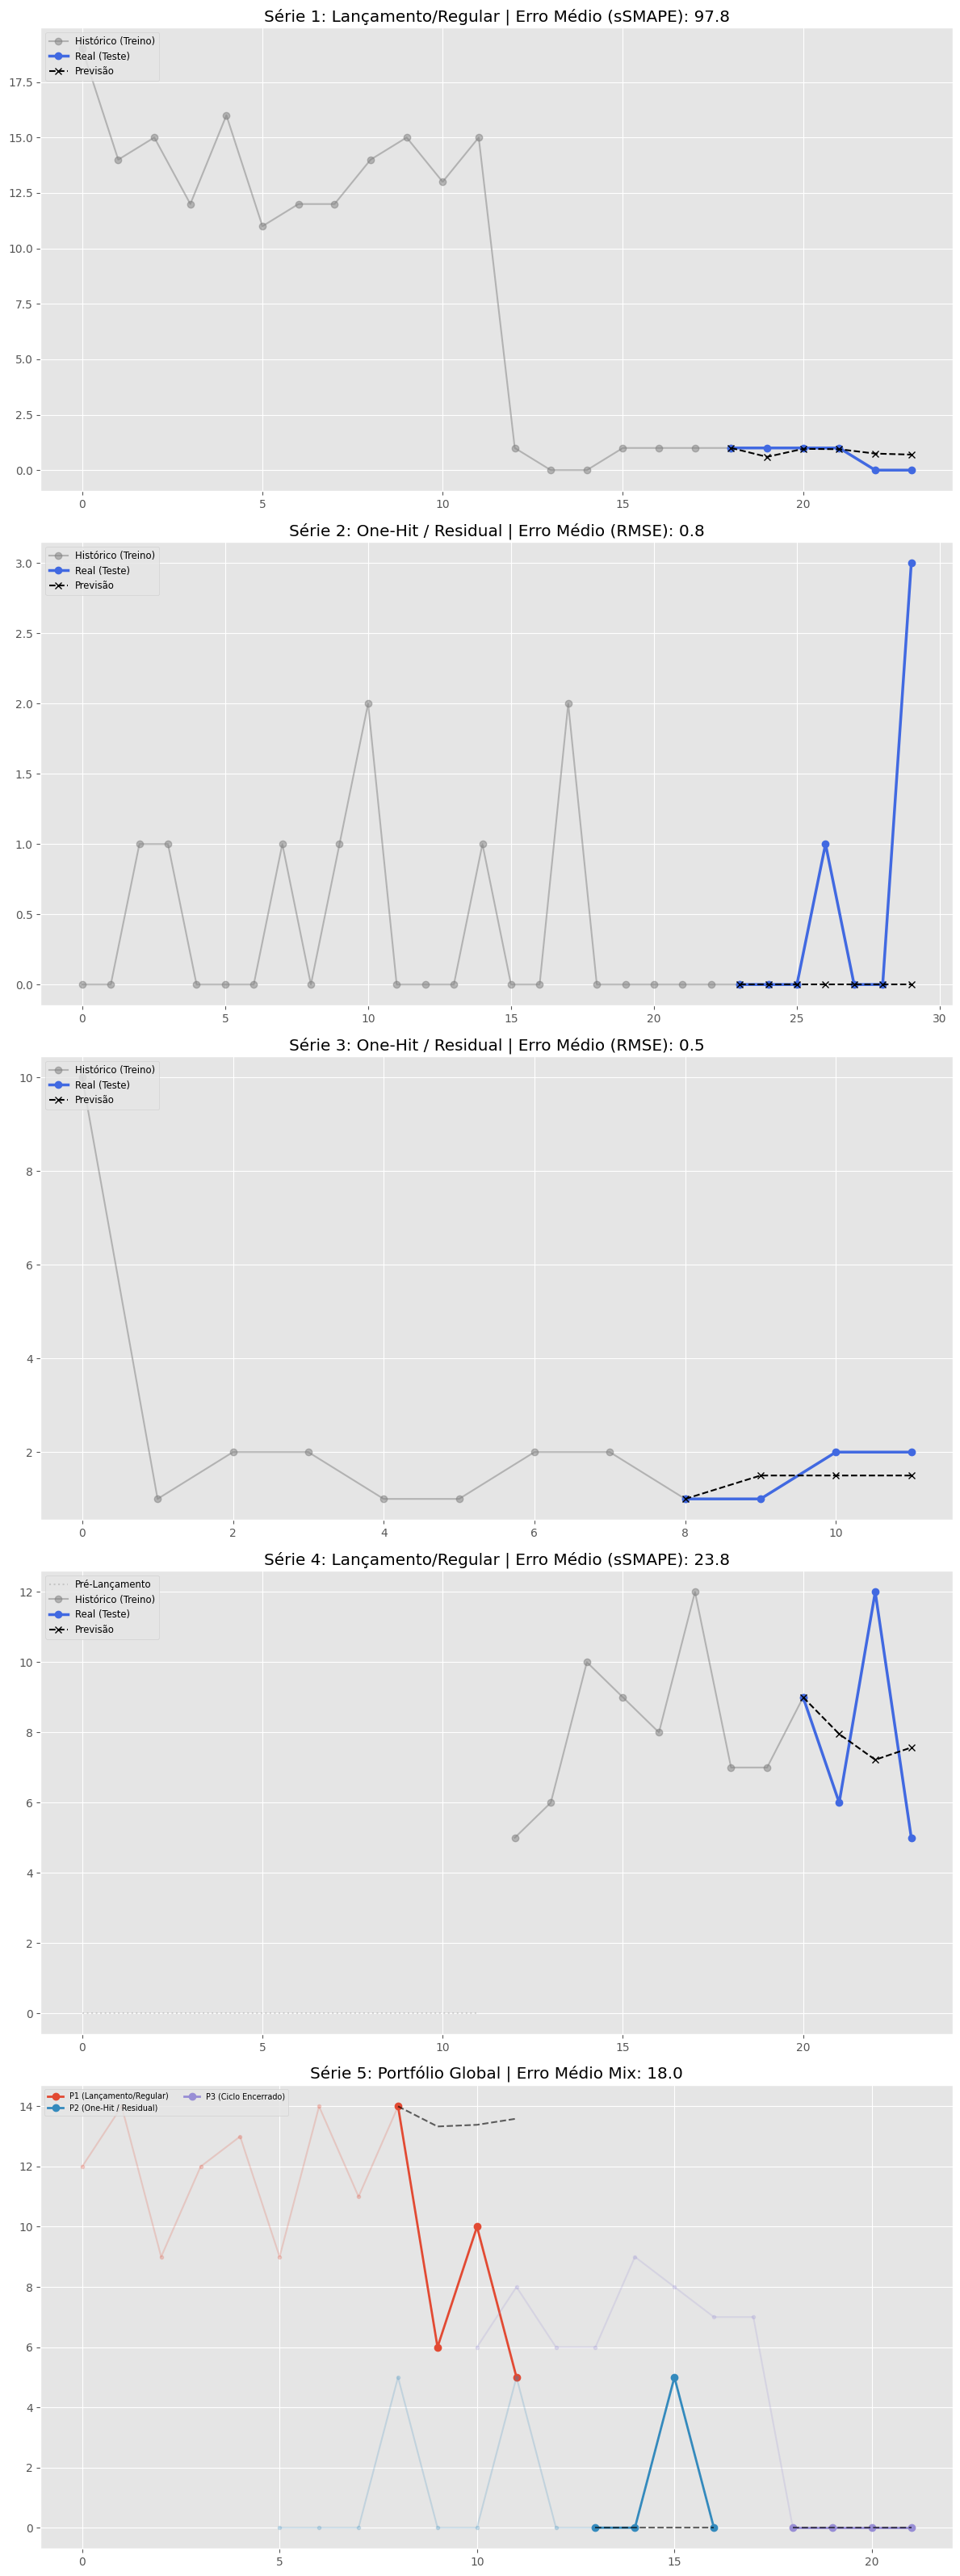


--- RESUMO EXECUTIVO DE PERFORMANCE ---
| Série   |   Erro Médio (100 Sims) |   Estabilidade (Desvio Padrão) |
|:--------|------------------------:|-------------------------------:|
| Série 1 |                    97.8 |                           46.4 |
| Série 2 |                     0.8 |                            0.5 |
| Série 3 |                     0.5 |                            0.2 |
| Série 4 |                    23.8 |                            7.7 |
| Série 5 |                    18   |                           16.2 |


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. CONFIGURAÇÕES E MOTOR DE MÉTRICAS ---
plt.style.use('ggplot')

def calculate_metric(y_true, y_pred, metric_name):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if metric_name == "RMSE":
        return np.sqrt(np.mean((y_true - y_pred)**2))
    elif metric_name == "WAPE":
        sum_true = np.sum(y_true)
        return np.sum(np.abs(y_true - y_pred)) / (sum_true + 1e-9) if sum_true > 0 else np.mean(np.abs(y_true - y_pred))
    elif metric_name == "MASE":
        return np.mean(np.abs(y_true - y_pred))
    elif metric_name == "sSMAPE":
        denom = (np.abs(y_true) + np.abs(y_pred))
        return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (denom + 1e-9))
    return 0

# --- 2. MOTOR DE DETECÇÃO E PREVISÃO ---
def autonomous_engine(y):
    n = len(y)
    split_idx = int(n * 0.8) - 1
    y_train, y_test = y[:split_idx + 1], y[split_idx:]
    
    sparsity = np.sum(y == 0) / n
    recent_zeros = np.sum(y_test == 0) / len(y_test)
    event_count = np.sum(y > 0)
    
    if event_count <= 2 or (np.max(y) > 0 and np.mean(y) < 0.3 * np.max(y)):
        tipo, metrica, model = "One-Hit / Residual", "RMSE", 'zero'
    elif recent_zeros > 0.8 and sparsity < 0.8:
        tipo, metrica, model = "Ciclo Encerrado", "MASE", 'zero'
    elif sparsity > 0.5:
        tipo, metrica, model = "Intermitente", "MASE", 'croston'
    else:
        tipo, metrica, model = "Lançamento/Regular", "sSMAPE", 'boost'

    if model == 'zero':
        val = np.mean(y_train[-2:]) if tipo == "One-Hit / Residual" else 0
        pred = np.full(len(y_test), val)
    elif model == 'croston':
        active = y_train[y_train > 0]
        val = np.mean(active) if len(active) > 0 else 0.5
        pred = np.full(len(y_test), val)
    else:
        val = np.mean(y_train[-3:]) if len(y_train) >= 3 else np.mean(y_train)
        pred = np.array([val + np.random.normal(0, 0.4) for _ in range(len(y_test))])
    
    pred[0] = y[split_idx] 
    return tipo, metrica, split_idx, y_test, pred, model

# --- 3. SIMULAÇÃO DE MONTE CARLO (100 RODADAS) ---
n_sims = 100
all_errors = {f"Série {i}": [] for i in range(1, 6)}
visual_samples = {}

for r in range(n_sims):
    s1 = np.concatenate([np.random.randint(10, 20, 12), np.random.randint(0, 2, 12)])
    s2 = np.random.choice([0, 1, 2, 3], 30, p=[0.8, 0.1, 0.05, 0.05])
    
    # Série 3: Residual
    max_s3 = 10
    s3 = np.array([max_s3] + [np.random.randint(1, 3) for _ in range(11)])
    
    # Série 4: Lançamento tardio (Começa na metade do tempo de 24 meses)
    s4_zeros = np.zeros(12)
    s4_vendas = np.random.randint(5, 15, 12)
    s4 = np.concatenate([s4_zeros, s4_vendas])
    
    s5_p = [np.random.randint(5, 15, 12), np.random.choice([0, 5], 12, p=[0.6, 0.4]), 
            np.concatenate([np.random.randint(5, 10, 8), np.zeros(4)])]

    for i, s in enumerate([s1, s2, s3, s4], 1):
        # Para Série 4, ignoramos os zeros iniciais na análise para detectar 'Lançamento'
        s_input = s[np.argmax(s > 0):] if i == 4 else s
        tipo, met, idx, yt, p, mod = autonomous_engine(s_input)
        err_val = calculate_metric(yt, p, met)
        all_errors[f"Série {i}"].append(err_val)
        if r == n_sims - 1: visual_samples[f"Série {i}"] = (s, s_input, tipo, met, idx, yt, p)

    round_s5_errors = []
    for p_data in s5_p:
        t, m, idx, yt, p, mod = autonomous_engine(p_data)
        round_s5_errors.append(calculate_metric(yt, p, m))
    all_errors["Série 5"].append(np.mean(round_s5_errors))
    if r == n_sims - 1: visual_samples["Série 5"] = (s5_p, "Portfólio", "Mix", 0, 0, 0)

# --- 4. PLOTAGEM ---
fig, axs = plt.subplots(5, 1, figsize=(12, 32))

for i in range(1, 5):
    s_orig, s_proc, tipo, met, idx, yt, p = visual_samples[f"Série {i}"]
    m_err = np.mean(all_errors[f"Série {i}"])
    
    # Ajuste de eixo X para séries com início tardio (Série 4)
    offset = len(s_orig) - len(s_proc)
    x_tr = np.arange(len(s_proc))[:idx+1] + offset
    x_ts = np.arange(len(s_proc))[idx:] + offset
    
    if offset > 0:
        axs[i-1].plot(np.arange(offset), s_orig[:offset], ':', color='gray', alpha=0.3, label='Pré-Lançamento')
        
    axs[i-1].plot(x_tr, s_proc[:idx+1], 'o-', color='gray', alpha=0.5, label='Histórico (Treino)')
    axs[i-1].plot(x_ts, yt, 'o-', color='royalblue', linewidth=2.5, label='Real (Teste)')
    axs[i-1].plot(x_ts, p, '--k', marker='x', label='Previsão')
    axs[i-1].set_title(f"Série {i}: {tipo} | Erro Médio ({met}): {m_err:.1f}")
    axs[i-1].legend(loc='upper left', fontsize='small')

# Série 5: Portfólio
s5_list, _, _, _, _, _ = visual_samples["Série 5"]
offsets_s5 = [0, 5, 10]
for j, p_data in enumerate(s5_list):
    t, m, idx, yt, p, mod = autonomous_engine(p_data)
    x_tr = np.arange(len(p_data))[:idx+1] + offsets_s5[j]
    x_ts = np.arange(len(p_data))[idx:] + offsets_s5[j]
    line, = axs[4].plot(x_tr, p_data[:idx+1], '.-', alpha=0.2)
    axs[4].plot(x_ts, yt, 'o-', color=line.get_color(), linewidth=2, label=f"P{j+1} ({t})")
    axs[4].plot(x_ts, p, '--k', alpha=0.6)

axs[4].set_title(f"Série 5: Portfólio Global | Erro Médio Mix: {np.mean(all_errors['Série 5']):.1f}")
axs[4].legend(loc='upper left', fontsize='x-small', ncol=2)

plt.tight_layout()
plt.show()

# --- 5. TABELA FINAL ---
report = []
for s_name, errs in all_errors.items():
    report.append({
        "Série": s_name,
        "Erro Médio (100 Simulacoes )": f"{np.mean(errs):.1f}",
        "Estabilidade (Desvio Padrão)": f"{np.std(errs):.1f}"
    })

print("\n--- RESUMO EXECUTIVO DE PERFORMANCE ---")
print(pd.DataFrame(report).to_markdown(index=False))